In [30]:
import numpy as np
import pandas as pd
import datetime 
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf#acf和pacf展示库
from statsmodels.tsa.stattools import adfuller#adf检验库
from statsmodels.stats.diagnostic import acorr_ljungbox#随机性检验库
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import prettytable 
import os
os.chdir('/Users/magictavern/Downloads')

In [31]:
def pre_table(table_name,table_rows):
    table=prettytable.PrettyTable()
    table.field_names=table_name
    for i in table_rows:
        table.add_row(i)
    return table

In [32]:
def get_best_log(ts,max_log=5,rule1=True,rule2=True):
    if rule1 and rule2:
        return 0, ts
    else:
        for i in range(1,max_log):
            ts=np.log(ts)
            lbvalue,pvalue2=acorr_ljungbox(ts,lags=1) #延迟期数=1，可以自定义6，12等
            adf,pvalue1,usedlag,nobs,critical_values,icbest=adfuller(ts)
            rule_1=(adf<critical_values['1%'] and adf <critical_values['5%']
                   and adf<critical_values['10%'] and pvalue1<0.01)
            rule_2=(pvalue2<0.05)
            rule_3=(i<5)
            if rule_1 and rule_2 and rule_3:
                print ('The best log n is :{0}'.format(i) )
            return i ,ts

In [33]:
def recover_log(ts,log_n):
    for i in range(1,log_n+1):
        ts=np.exp(ts)
        return ts

In [34]:
def adf_val(ts,ts_title,acf_title,pacf_title):
    plt.figure()
    plt.plot(ts)
    plt.title(ts_title)
    plt.show()
    plot_acf(ts,lags=20,title=acf_title).show()
    plot_pacf(ts,lags=20,title=pacf_title).show()
    adf,pvalue,usedlag,nobs,critical_values,icbest=adfuller(ts)
    table_name=['adf','pvalue','usedlag','nobs','critical_values','icbest']
    table_rows=[[adf,pvalue,usedlag,nobs,critical_values,icbest]]
    adf_table=pre_table(table_name,table_rows)
    print ('stochastic score')
    print (adf_table)
    return adf,pvalue,critical_values

In [35]:
def acorr_val(ts):
    lbvalue,pvalue=acorr_ljungbox(ts,lags=1)
    table_name=['lbvalue','pvalue']
    table_rows=[[lbvalue,pvalue]]
    acorr_ljungbox_table=pre_table(table_name,table_rows)
    print ('stationary score')
    print (acorr_ljungbox_table)
    return pvalue

In [36]:
def arma_fit(ts):
    max_count=int(len(ts)/10)
    bic=float('inf')
    tmp_score=[]
    for tmp_p in range(max_count+1):
        for tmp_q in range(max_count+1):
            model=ARMA(ts,order=(tmp_p,tmp_q))
            try:
                results_ARMA=model.fit(disp=-1,method='css')
            except:
                continue
            finally:
                tmp_aic=results_ARMA.aic
                tmp_bic=results_ARMA.bic
                tmp_hqic=results_ARMA.hqic
                tmp_score.append([tmp_p,tmp_q,tmp_aic,tmp_bic,tmp_hqic])
                if tmp_bic<bic:
                    p=tmp_p
                    q=tmp_q
                    model_arma=results_ARMA
                    aic=tmp_aic
                    bic=tmp_bic
                    hqic=tmp_hqic
    pdq_metrix=np.array(tmp_score)
    pdq_pd=pd.DataFrame(pdq_metrix,columns=['p','q','aic','bic','hqic'])
    table_name=['p','q','aic','bic','hqic']
    table_rows=[[p,q,aic,bic,hqic]]
    parameter_table=pre_table(table_name,table_rows)
    print('each p/q traning record')
    print (pdq_pd)
    print('best p and q')
    print (parameter_table)
    return model_arma

In [37]:
def train_test(model_arma,ts,log_n,rule1=True,rule2=True):
    train_predict=model_arma.predict()
    if not (rule1 and rule2):
        train_predict=recover_log(train_predict,log_n)
        ts=recover_log(ts,log_n)
    ts_data_new=ts[train_predict.index]
    RMSE=np.sqrt(np.sum((train_predict-ts_data_new)**2)/ts_data_new.size)
    plt.figure()
    train_predict.plot(label='predicted data',style='--')
    ts_data_new.plot(label='raw data')
    plt.legend(loc='best')
    plt.title('raw data and predicted data with RMSE of %.2f'%RMSE)
    plt.show()
    return ts

In [38]:
def predict_data(model_arma,ts,log_n,start,end,rule1=True,rule2=True):
    predict_ts=model_arma.predict(start=start,end=end)
    print('-----------predict date-----------')
    if not (rule1 and rule2):
        predict_ts=recover_log(predict_ts,log_n)
        print (predict_ts)
    plt.figure()
    ts.plot(label='raw time series')
    predict_ts.plot(label='predicted data',style='--')
    plt.legend(loc='best')
    plt.title('predicted time series')
    plt.show()

In [59]:
date_parse=lambda dates:pd.datetime.strptime(dates,'%m-%d-%Y')
df=pd.read_table('/Users/magictavern/Boyu/python_book/chapter4/time_series.txt',
                delimiter='\t',index_col='date',date_parser=date_parse)
ts_data=df['number'].astype('float32')
print ('data summary')
print (ts_data)

data summary
date
1991-03-01    281.0
1991-03-02    304.0
1991-03-03    292.0
1991-03-04    360.0
1991-03-05    320.0
1991-03-06    185.0
1991-03-07    300.0
1991-03-08    297.0
1991-03-09    301.0
1991-03-10    199.0
1991-03-11    210.0
1991-03-12    377.0
1991-03-13    361.0
1991-03-14    349.0
1991-03-15    400.0
1991-03-16    175.0
1991-03-17    210.0
1991-03-18    300.0
1991-03-19    160.0
1991-03-20    140.0
1991-03-21    327.0
1991-03-22    166.0
1991-03-23    280.0
1991-03-24    307.0
1991-03-25    189.0
1991-03-26    161.0
1991-03-27     99.0
1991-03-28     80.0
1991-03-29     77.0
1991-03-30     90.0
              ...  
1991-06-28     99.0
1991-06-29    116.0
1991-06-30     96.0
1991-07-01     60.0
1991-07-02     71.0
1991-07-03    112.0
1991-07-04    121.0
1991-07-05    113.0
1991-07-06    140.0
1991-07-07     92.0
1991-07-08    191.0
1991-07-09     99.0
1991-07-10    110.0
1991-07-11    167.0
1991-07-12     90.0
1991-07-13     90.0
1991-07-14    161.0
1991-07-15    196.0
19

In [84]:
increase_rate=pd.read_csv('increase_rate.csv')
ts_data=pd.Series(increase_rate.dropna().loc[:,'2017-11-01'])
ts_data

0      1.773534
1      1.398627
2      1.244074
3      1.170907
4      1.157615
5      1.135283
6      1.086424
7      1.091836
8      1.070404
9      1.062977
10     1.055656
11     1.063092
12     1.057356
13     1.046986
14     1.053852
15     1.046770
16     1.047084
17     1.041178
18     1.030939
19     1.031913
20     1.036650
21     1.031128
22     1.025235
23     1.027752
24     1.025036
25     1.027064
26     1.020792
27     1.021077
28     1.022506
29     1.023819
         ...   
209    1.001658
210    1.002612
211    1.002028
212    1.002817
213    1.001935
214    1.002064
215    1.001841
216    1.002783
217    1.002395
218    1.002994
219    1.003571
220    1.004543
221    1.001579
222    1.001695
223    1.001462
224    1.001590
225    1.003580
226    1.003481
227    1.001943
228    1.002698
229    1.003932
230    1.002696
231    1.003775
232    1.002388
233    1.003116
234    1.003948
235    1.002324
236    1.002570
237    1.002073
238    1.002284
Name: 2017-11-01, Length

In [92]:
date_index=[]
for i in range(239):
    date_add=datetime.datetime.strptime('2017-11-01','%Y-%m-%d')+timedelta(days=i)
    date_index.append(date_add)

In [100]:
increase_rate=pd.read_csv('increase_rate.csv')
raw_data=pd.Series(increase_rate.dropna().loc[:,'2017-11-01'])

In [103]:
raw_data.index=date_index
raw_data

2017-11-01    1.773534
2017-11-02    1.398627
2017-11-03    1.244074
2017-11-04    1.170907
2017-11-05    1.157615
2017-11-06    1.135283
2017-11-07    1.086424
2017-11-08    1.091836
2017-11-09    1.070404
2017-11-10    1.062977
2017-11-11    1.055656
2017-11-12    1.063092
2017-11-13    1.057356
2017-11-14    1.046986
2017-11-15    1.053852
2017-11-16    1.046770
2017-11-17    1.047084
2017-11-18    1.041178
2017-11-19    1.030939
2017-11-20    1.031913
2017-11-21    1.036650
2017-11-22    1.031128
2017-11-23    1.025235
2017-11-24    1.027752
2017-11-25    1.025036
2017-11-26    1.027064
2017-11-27    1.020792
2017-11-28    1.021077
2017-11-29    1.022506
2017-11-30    1.023819
                ...   
2018-05-29    1.001658
2018-05-30    1.002612
2018-05-31    1.002028
2018-06-01    1.002817
2018-06-02    1.001935
2018-06-03    1.002064
2018-06-04    1.001841
2018-06-05    1.002783
2018-06-06    1.002395
2018-06-07    1.002994
2018-06-08    1.003571
2018-06-09    1.004543
2018-06-10 

In [118]:
ts_data=raw_data[:200]
ts_data

2017-11-01    1.773534
2017-11-02    1.398627
2017-11-03    1.244074
2017-11-04    1.170907
2017-11-05    1.157615
2017-11-06    1.135283
2017-11-07    1.086424
2017-11-08    1.091836
2017-11-09    1.070404
2017-11-10    1.062977
2017-11-11    1.055656
2017-11-12    1.063092
2017-11-13    1.057356
2017-11-14    1.046986
2017-11-15    1.053852
2017-11-16    1.046770
2017-11-17    1.047084
2017-11-18    1.041178
2017-11-19    1.030939
2017-11-20    1.031913
2017-11-21    1.036650
2017-11-22    1.031128
2017-11-23    1.025235
2017-11-24    1.027752
2017-11-25    1.025036
2017-11-26    1.027064
2017-11-27    1.020792
2017-11-28    1.021077
2017-11-29    1.022506
2017-11-30    1.023819
                ...   
2018-04-20    1.003337
2018-04-21    1.003475
2018-04-22    1.002602
2018-04-23    1.003597
2018-04-24    1.003290
2018-04-25    1.001944
2018-04-26    1.003574
2018-04-27    1.003236
2018-04-28    1.003229
2018-04-29    1.003828
2018-04-30    1.002910
2018-05-01    1.003892
2018-05-02 

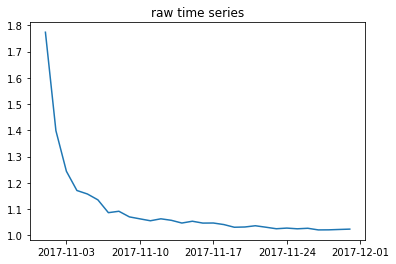

stochastic score
+---------------------+---------------------+---------+------+---------------------------------------------------------------------------+--------------------+
|         adf         |        pvalue       | usedlag | nobs |                              critical_values                              |       icbest       |
+---------------------+---------------------+---------+------+---------------------------------------------------------------------------+--------------------+
| -2.2428583809732903 | 0.19105950913154618 |    9    |  20  | {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125} | -157.2864980266581 |
+---------------------+---------------------+---------+------+---------------------------------------------------------------------------+--------------------+
stationary score
+-------------+--------------+
|   lbvalue   |    pvalue    |
+-------------+--------------+
| [8.8511277] | [0.00292908] |
+-------------+--------------+


/Users/magictavern/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


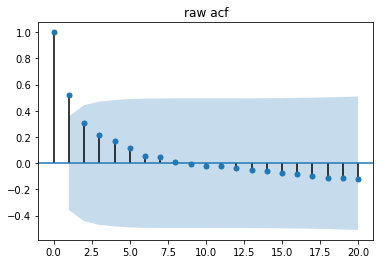

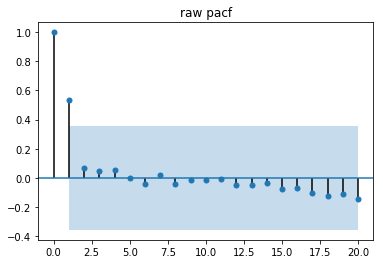

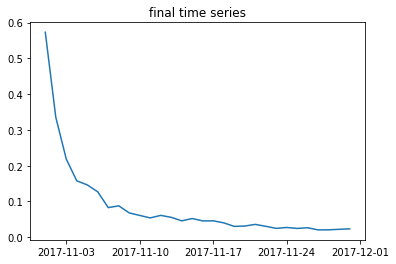

/Users/magictavern/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency infor

stochastic score
+---------------------+--------------------+---------+------+---------------------------------------------------------------------------+---------------------+
|         adf         |       pvalue       | usedlag | nobs |                              critical_values                              |        icbest       |
+---------------------+--------------------+---------+------+---------------------------------------------------------------------------+---------------------+
| -1.9112307462595466 | 0.3267963977346916 |    9    |  20  | {'1%': -3.8092091249999998, '5%': -3.0216450000000004, '10%': -2.6507125} | -156.47886033220124 |
+---------------------+--------------------+---------+------+---------------------------------------------------------------------------+---------------------+
stationary score
+---------------+--------------+
|    lbvalue    |    pvalue    |
+---------------+--------------+
| [11.24103355] | [0.00080009] |
+---------------+--------------+


/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/magictavern/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_par

each p/q traning record
      p    q         aic         bic        hqic
0   0.0  0.0  -41.810839  -39.008444  -40.914328
1   0.0  1.0  -49.048587  -44.844995  -47.703822
2   0.0  2.0  -49.815973  -44.211184  -48.022953
3   0.0  3.0  -48.643629  -41.637643  -46.402354
4   1.0  0.0 -169.809422 -165.707535 -168.524762
5   1.0  1.0 -170.816276 -165.347092 -169.103396
6   1.0  2.0 -170.662266 -163.825787 -168.521166
7   1.0  3.0 -175.542353 -167.338578 -172.973033
8   2.0  0.0 -174.208837 -168.880019 -172.579764
9   2.0  1.0 -192.310266 -185.649243 -190.273925
10  2.0  2.0 -193.076459 -185.083232 -190.632850
11  2.0  3.0 -197.096782 -187.771350 -194.245904
12  3.0  0.0 -171.668397 -165.189213 -169.741796
13  3.0  1.0 -184.564925 -176.789904 -182.253004
14  3.0  2.0 -184.340909 -175.270051 -181.643667
15  3.0  3.0 -180.622909 -170.256215 -177.540348
best p and q
+---+---+--------------------+---------------------+--------------------+
| p | q |        aic         |         bic         |    

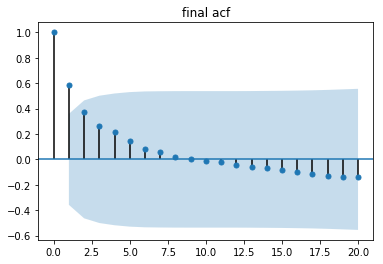

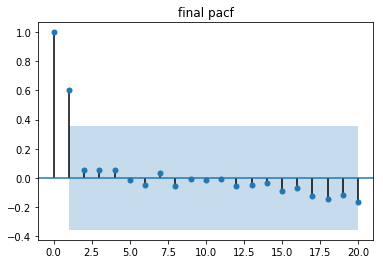

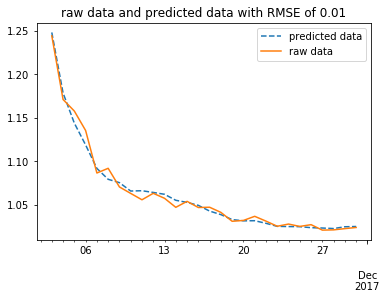

-----------predict date-----------
2017-11-21    1.031591
2017-11-22    1.028614
2017-11-23    1.025117
2017-11-24    1.024874
2017-11-25    1.024761
2017-11-26    1.023598
2017-11-27    1.023191
2017-11-28    1.022592
2017-11-29    1.024636
2017-11-30    1.024947
2017-12-01    1.024857
2017-12-02    1.023817
2017-12-03    1.022625
2017-12-04    1.021944
2017-12-05    1.021509
2017-12-06    1.021198
2017-12-07    1.020957
2017-12-08    1.020760
2017-12-09    1.020593
2017-12-10    1.020450
2017-12-11    1.020325
2017-12-12    1.020216
2017-12-13    1.020121
2017-12-14    1.020037
2017-12-15    1.019964
2017-12-16    1.019900
2017-12-17    1.019843
2017-12-18    1.019794
2017-12-19    1.019750
2017-12-20    1.019712
                ...   
2018-05-29    1.019439
2018-05-30    1.019439
2018-05-31    1.019439
2018-06-01    1.019439
2018-06-02    1.019439
2018-06-03    1.019439
2018-06-04    1.019439
2018-06-05    1.019439
2018-06-06    1.019439
2018-06-07    1.019439
2018-06-08    1.019439

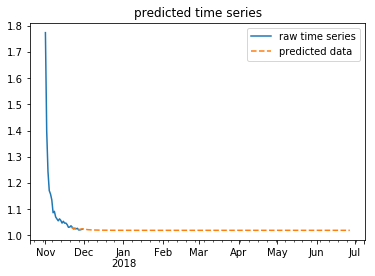

In [113]:
adf,pvalue1,critical_values=adf_val(ts_data,'raw time series','raw acf','raw pacf')
pvalue2=acorr_val(ts_data)
rule1=(adf<critical_values['1%'] and adf < critical_values['5%'] and adf<critical_values['10%'] and pvalue1<0.01)
rule2=(pvalue2[0,]<0.05)
log_n,ts_data=get_best_log(ts_data,max_log=5,rule1=rule1,rule2=rule2)
adf,pvalue1,critical_values=adf_val(ts_data,'final time series','final acf','final pacf')
pvalue2=acorr_val(ts_data)
model_arma=arma_fit(ts_data)
ts_data=train_test(model_arma,ts_data,log_n,rule1=rule1,rule2=rule2)
start='2017-11-21'
end='2018-06-27'
predict_data(model_arma,ts_data,log_n,start,end,rule1=rule1,rule2=rule2)